#Imports

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Tables

In [0]:
CUSTOMERS_DF = 'olist_customers_dataset.csv'
GEOLOCATION_DF = 'olist_geolocation_dataset.csv'
ORDER_ITEMS_DF = 'olist_order_items_dataset.csv'
ORDER_PAYMENTS_DF = 'olist_order_payments_dataset.csv'
ORDER_REVIEWS_DF = 'olist_order_reviews_dataset.csv'
ORDERS_DF = 'olist_orders_dataset.csv'
PRODUCTS_DF = 'olist_products_dataset.csv'
SELLERS_DF = 'olist_sellers_dataset.csv'
CATEGORY_TRANSLATION_DF = 'product_category_name_translation.csv'

#DataFrames

In [0]:
customers_df = pd.read_csv(CUSTOMERS_DF)
geolocation_df = pd.read_csv(GEOLOCATION_DF)
order_items_df = pd.read_csv(ORDER_ITEMS_DF)
order_payments_df = pd.read_csv(ORDER_PAYMENTS_DF)
order_reviews_df = pd.read_csv(ORDER_REVIEWS_DF)
orders_df = pd.read_csv(ORDERS_DF)
products_df = pd.read_csv(PRODUCTS_DF)
sellers_df = pd.read_csv(SELLERS_DF)
category_translation_df = pd.read_csv(CATEGORY_TRANSLATION_DF)

# Data Preprocessing and Merging

In [0]:
products_df = pd.merge(left=products_df, right=category_translation_df, how='left', on='product_category_name')
merged_df = pd.merge(left=orders_df, right=order_payments_df, how='inner', on='order_id')
merged_df = pd.merge(left=merged_df, right=customers_df, how='inner', on='customer_id')
merged_df = pd.merge(left=merged_df, right=order_reviews_df, how='inner', on='order_id')
merged_df = pd.merge(left=merged_df, right=order_items_df, how='inner', on='order_id')
merged_df = pd.merge(left=merged_df, right=products_df, how='inner', on='product_id')
merged_df = pd.merge(left=merged_df, right=sellers_df, how='inner', on='seller_id')

In [0]:
merged_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

# Initial Data Cleaning

In [0]:
merged_df['review_score'] = pd.to_numeric(merged_df['review_score'], errors='coerce')
merged_df.dropna(subset=['review_score'], inplace=True)

# Product Clustering
### Product Feature Engineering

In [0]:
products_aggregated_df = (
    merged_df.groupby('product_id')
    .agg(
        mean_price=('price', 'mean'),
        mean_freight_value=('freight_value', 'mean'),
        mean_product_photos_qty=('product_photos_qty', 'mean'),
        mean_product_description_length=('product_description_lenght', 'mean'),
        category_name=('product_category_name_english', 'first')
        )
    .reset_index()
)

display(products_aggregated_df.head())

product_id,mean_price,mean_freight_value,mean_product_photos_qty,mean_product_description_length,category_name
00066f42aeeb9f3007548bb9d3f33c38,101.65,18.59,6.0,596.0,perfumery
00088930e925c41fd95ebfe695fd2655,129.9,13.93,4.0,752.0,auto
0009406fd7479715e4bef61dd91f2462,229.0,13.1,2.0,266.0,bed_bath_table
000b8f95fcb9e0096488278317764d19,58.9,19.6,3.0,364.0,housewares
000d9be29b5207b54e86aa1b1ac54872,199.0,19.27,4.0,613.0,watches_gifts


### Product Data Preparation

In [0]:
product_features_for_clustering = products_aggregated_df[[
    'mean_price', 
    'mean_freight_value', 
    'mean_product_photos_qty', 
    'mean_product_description_length'
]].copy()

for column in product_features_for_clustering.columns:
    if product_features_for_clustering[column].isnull().any():
        product_features_for_clustering[column].fillna(product_features_for_clustering[column].mean(), inplace=True)

### Scaling Product Features

In [0]:
scaler_products = StandardScaler()
product_features_scaled = scaler_products.fit_transform(product_features_for_clustering)

### Determining Optimal Number of Clusters (Elbow Method) - Products

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xfca55ab63ce0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

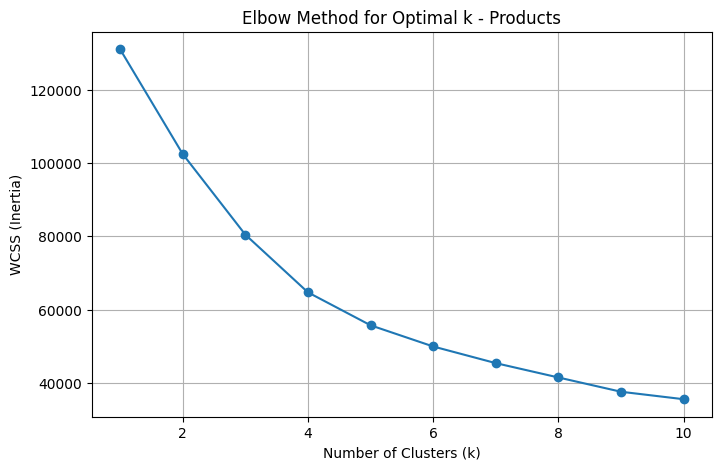

In [0]:
wcss_products = []
k_range_products = range(1, 11)

for k in k_range_products:
    kmeans_products_elbow = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_products_elbow.fit(product_features_scaled)
    wcss_products.append(kmeans_products_elbow.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range_products, wcss_products, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k - Products')
plt.grid(True)
plt.show()

### Applying K-Means Clustering 

In [0]:
optimal_k_products = 4
kmeans_products = KMeans(n_clusters=optimal_k_products, random_state=42, n_init=10)
products_aggregated_df['cluster'] = kmeans_products.fit_predict(product_features_scaled)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xfca540445440>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

### Product Cluster Analysis

In [0]:
product_cluster_profile = products_aggregated_df.groupby('cluster').agg(
    mean_price=('mean_price', 'mean'),
    mean_freight_value=('mean_freight_value', 'mean'),
    mean_product_photos_qty=('mean_product_photos_qty', 'mean'),
    mean_product_description_length=('mean_product_description_length', 'mean'),
    product_count=('product_id', 'count')
).round(2).reset_index()

display(product_cluster_profile)

cluster,mean_price,mean_freight_value,mean_product_photos_qty,mean_product_description_length,product_count
0,118.23,19.62,5.35,714.16,4817
1,103.98,18.36,1.49,528.71,22364
2,937.81,81.51,2.54,1077.81,1217
3,164.83,20.73,2.08,1956.84,4391


### Insights from Product Clusters

---
#### Cluster 0 – Marketing Visual Forte, Preço Intermediário  
- Características: Preço médio deR$ 118,23, com maior número de foto entre os clusters e descrições mais básicas.  
- Interpretação: Produtos com forte apelo visual, possivelmente voltados para moda, decoração ou similares, que não exigem grande detalhamento textual.  
- Ação sugerida: Testar o uso de vídeos demonstrativo para potencializar a conversão.

--- 

#### Cluster 1 – Alta Popularidade, Preço Baixo, Baixo Investimento em Marketing  
- Características: Preço médio de R$ 103,98, maior volume de estoque (22 mil unidades), com poucas foto e descrições curta.  
- Interpretação: Produtos de uso comum e recorrente, com alto apelo de compra por impulso, não exigindo muita explicação.  
- Ação sugerida: Aumentar o investimento em marketing (fotos e descrição) para maximizar a conversão de produtos já populares.

--- 

#### Cluster 2 – Linha Premium de Alto Custo  
- Características: Produtos com preço médio e frete mais elevado.  
- Interpretação: Itens com maior potencial de margem, mas que podem enfrentar barreiras na conversão devido ao alto custo para o consumidor.  
- Ação sugerida: Revisar a logística e a política de frete, visando reduzir o preço final ao consumido e aumentar a taxa de conversão, mantendo ou otimizando a margem.

--- 

#### Cluster 3 – Produtos Técnicos ou Complexos  
- Características: Preço médio de R$ 164,83, com a maior média de caracteres nas descrições.  
- Interpretação: Produtos que exigem explicações mais detalhadas para transmitir segurança e clareza ao consumidor.  
- Ação sugerida: Criar tutoriais e investir moderadamente em marketing visual para aumentar a confiança e melhorar a taxa de conversão.
